In [1]:
%pylab
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
def encode_manchester(bits):
    manchester = np.array([[False, True] if b else [True, False] for b in bits])
    manchester = np.reshape(manchester, (-1, 1))
    return manchester

In [3]:
def generate_am_signal(manchester_encoding, samp_per_bit, num_samples, samp_rate):
    M = np.tile(manchester_encoding,(1,int(samp_per_bit)))
    t = r_[0.0:2*num_samples]/samp_rate
    am_signal = M.ravel()*np.sin(2*np.pi*f0*t)
    return am_signal, t

In [9]:
def transmit(data, samp_rate, baud, frequency, len_preamble):
    samp_per_bit = samp_rate/baud
    len_packet =  len_preamble + len(data)
    num_samples = len_packet * samp_per_bit
    preamble = np.array([[True] if i % 2 == 0 else [False] for i in range(len_preamble)])
    bits = np.concatenate((preamble, data))
    manchester = encode_manchester(bits)
    am_signal, t = generate_am_signal(manchester, samp_per_bit, num_samples, samp_rate)
    sd.play(am_signal, blocking=True)
    return bits, am_signal, t

[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1]


Text(0.5,0,'time [s]')

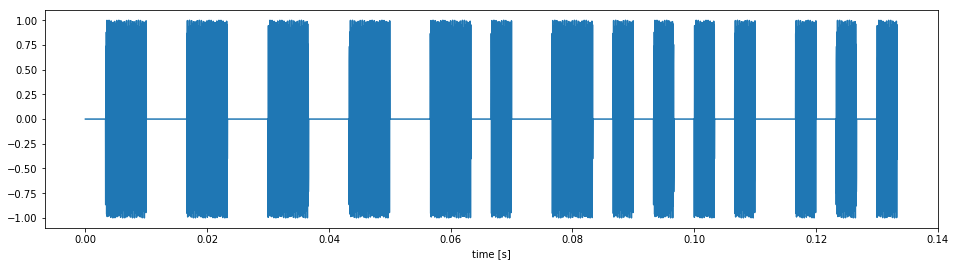

In [10]:
samp_rate = 44100  # sampling rate
baud = 300  # symbol rate
len_preamble = 10
len_data = 10  # number of bits
frequency = int(88.1e6)
data = randn(len_data,1) > 0

bits, am_signal, t = transmit(data, samp_rate, baud, frequency, len_preamble)
output = []
for b in bits:
    if b:
        output.append(1)
    else:
        output.append(0)
print(output)
fig = figure(figsize = (16,4))
plot(t, am_signal)
xlabel('time [s]')